In [1]:
using Flux
using BSON
using HDF5
using PGFPlots

# Load in the networks and data:

In [2]:
# g128x2 = BSON.load("../gan_training/generators/mlp128x2_generator_uniform.bson")[:g]
# g128x4 = BSON.load("../gan_training/generators/mlp128x4_generator_uniform.bson")[:g]
# g256x2 = BSON.load("../gan_training/generators/mlp256x2_generator_uniform.bson")[:g]
# g256x4 = BSON.load("../gan_training/generators/mlp256x4_generator_uniform.bson")[:g];

In [3]:
# g256x4old = BSON.load("../gan_training/generators/bigmlp_generator_uniform.bson")[:g];

In [4]:
# g256x4mae = BSON.load("../gan_training/generators/mlp256x4_mae_generator_uniform.bson")[:g];

In [5]:
# g256x4msle = BSON.load("../gan_training/generators/mlp256x4_msle_generator_uniform.bson")[:g];

In [6]:
fn = "data/SK_DownsampledGANFocusAreaData.h5"
images = h5read(fn, "y_train")
real_images = reshape(images, 16*8, :)
y = h5read(fn, "X_train")[1:2, :];

### Convolutional Generator

In [7]:
struct TaxiGConv
    g_labels          # Submodel to take labels as input and convert it to the shape of (7, 7, 1, batch_size) 
    g_latent          # Submodel to take latent_dims as input and convert it to shape of (7, 7, 128, batch_size)
    g_common    
end

function (m::TaxiGConv)(x)
    t = cat(m.g_labels(x[3:4, :]), m.g_latent(x[1:2, :]), dims=3)
    return m.g_common(t)
end

In [8]:
# gconv = BSON.load("../gan_training/generators/conv_generator_ld2.bson")[:G];

In [9]:
gconv2 = BSON.load("conv_generator_ld2.bson")[:G]
gconv3 = BSON.load("conv_generator_ld3.bson")[:G]
gconv6 = BSON.load("conv_generator_ld6.bson")[:G]
gconv12 = BSON.load("conv_generator_ld12.bson")[:G]
gconv24 = BSON.load("conv_generator_ld24.bson")[:G]
gconv50 = BSON.load("conv_generator_ld50.bson")[:G]
gconv100 = BSON.load("conv_generator_ld100.bson")[:G]

TaxiGConv(Chain(Dense(2, 49), #45), Chain(Dense(100, 6272), #46, #47), Chain(ConvTranspose((4, 4), 129=>128), BatchNorm(128, leakyrelu), Dropout(0.25), ConvTranspose((4, 4), 128=>64), BatchNorm(64, leakyrelu), Conv((5, 5), 64=>1, tanh)))

In [10]:
function vary_sample_size_conv(generator, sizes, real_images; k = 10)
    # Get the fake images to cover all sizes
    inputs = get_inputs(maximum(sizes))
    fake_images = zeros(16, 8, size(inputs, 2))
    for i = 1:size(inputs, 2)
        i % 5000 == 0 && (println(i))
        fake_images[:, :, i] = generator(inputs[:, i])[:, :, 1, 1]
    end
    fake_images = (reshape(fake_images, 128, :) .+ 1f0) ./ 2f0

    # Vary the size
    recalls = zeros(length(sizes))
    for i = 1:length(sizes)
        #println(i)
        recalls[i] = recall(fake_images[:, 1:sizes[i]], real_images, k = k)
    end

    return recalls
end

vary_sample_size_conv (generic function with 1 method)

In [11]:
GC.gc()

### Reconstruction Generator

In [128]:
# grecons = BSON.load("../gan_training/generators/reconstruction_generator.bson")[:g];

In [143]:
# function vary_sample_size_recons(generator, sizes, real_images; k = 10)
#     # Get the fake images to cover all sizes
#     inputs = get_inputs(maximum(sizes))
#     fake_images = generator(inputs[1:2, :])

#     # Vary the size
#     recalls = zeros(length(sizes))
#     for i = 1:length(sizes)
#         #println(i)
#         recalls[i] = recall(fake_images[:, 1:sizes[i]], real_images, k = k)
#     end

#     return recalls
# end

vary_sample_size_recons (generic function with 1 method)

### Big MLP

In [141]:
# gdisc = BSON.load("../gan_training/generators/bigmlp_generator_normalnoise_permuted.bson")[:Gbig];

In [148]:
# function vary_sample_size_disc(generator, sizes, real_images; k = 10)
#     # Get the fake images to cover all sizes
#     inputs = get_inputs(maximum(sizes), latent_dist = Truncated(Normal(0, 1), -1, 1))
    
#     fake_images = generator(inputs)
# 	fake_images = permutedims(fake_images, [2, 1, 3, 4])
# 	fake_images = (reshape(fake_images, 128, :) .+ 1f0) ./ 2f0

#     # Vary the size
#     recalls = zeros(length(sizes))
#     for i = 1:length(sizes)
#         #println(i)
#         recalls[i] = recall(fake_images[:, 1:sizes[i]], real_images, k = k)
#     end

#     return recalls
# end

vary_sample_size_disc (generic function with 1 method)

# Recall Tuning

In [12]:
include("gan_evaluation.jl");

In [13]:
sizes = [10000, 30000, 50000];

In [ ]:
recalls_conv2 = vary_sample_size(gconv2, sizes, real_images; k=30)

In [ ]:
recalls_conv3 = vary_sample_size(gconv3, sizes, real_images; k=30)

In [ ]:
recalls_conv6 = vary_sample_size(gconv6, sizes, real_images; k=30)

In [ ]:
recalls_conv12 = vary_sample_size(gconv12, sizes, real_images; k=30)

In [ ]:
recalls_conv24 = vary_sample_size(gconv24, sizes, real_images; k=30)

In [ ]:
recalls_conv50 = vary_sample_size(gconv50, sizes, real_images; k=30)

In [ ]:
recalls_conv100 = vary_sample_size(gconv100, sizes, real_images; k=30)

In [117]:
# recalls128x2 = vary_sample_size(g128x2, sizes, real_images; k = 30)
# recalls128x4 = vary_sample_size(g128x4, sizes, real_images; k = 30)
# recalls256x2 = vary_sample_size(g256x2, sizes, real_images; k = 30);

In [121]:
# recalls256x4 = vary_sample_size(g256x4, sizes, real_images; k = 30);

1
2
3
4
5
6


In [ ]:
# recalls256x4old = vary_sample_size(g256x4old, sizes, real_images; k = 30);

In [123]:
# recalls256x4mae = vary_sample_size(g256x4mae, sizes, real_images; k = 30);

1
2
3
4
5
6


In [134]:
# recalls256x4msle = vary_sample_size(g256x4msle, sizes, real_images; k = 30);

1
2
3
4
5
6


In [118]:
# recallsconv = vary_sample_size_conv(gconv, sizes, real_images; k = 30);

In [131]:
# recallsrecons = vary_sample_size_recons(grecons, sizes, real_images; k = 30);

In [149]:
# recallsdisc = vary_sample_size_disc(gdisc, sizes, real_images; k = 30);

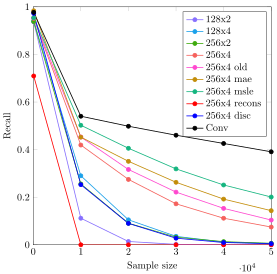

In [156]:
ax = Axis(Plots.Linear(sizes, recalls128x2, mark = "*", legendentry = "128x2",
        style = "thick"), 
            xmin = 0.0, xmax = 50000.0, ymin = 0.0, ymax = 1.0, 
    style = "cycle list name = pastelcolors")
# push!(ax, Plots.Linear(sizes, recalls128x4, mark = "*", legendentry = "128x4",
#         style = "thick"))
# push!(ax, Plots.Linear(sizes, recalls256x2, mark = "*", legendentry = "256x2",
#         style = "thick"))
# push!(ax, Plots.Linear(sizes, recalls256x4, mark = "*", legendentry = "256x4",
#         style = "thick"))
# push!(ax, Plots.Linear(sizes, recalls256x4old, mark = "*", legendentry = "256x4 old",
#         style = "thick"))
# push!(ax, Plots.Linear(sizes, recalls256x4mae, mark = "*", legendentry = "256x4 mae",
#         style = "thick"))
# push!(ax, Plots.Linear(sizes, recalls256x4msle, mark = "*", legendentry = "256x4 msle",
#         style = "thick"))
# push!(ax, Plots.Linear(sizes, recallsrecons, mark = "*", legendentry = "256x4 recons",
#         style = "red, thick"))
# push!(ax, Plots.Linear(sizes, recallsdisc, mark = "*", legendentry = "256x4 disc",
#         style = "blue, thick"))
# push!(ax, Plots.Linear(sizes, recallsconv, mark = "*", legendentry = "Conv",
#         style = "black, thick"))
push!(ax, Plots.Linear(sizes, recalls_conv2, mark = "*", legendentry = "Conv - 2 LD",
        style = "black, thick"))
push!(ax, Plots.Linear(sizes, recalls_conv3, mark = "*", legendentry = "Conv - 3 LD",
        style = "black, thick"))
push!(ax, Plots.Linear(sizes, recalls_conv6, mark = "*", legendentry = "Conv - 6 LD",
        style = "black, thick"))
push!(ax, Plots.Linear(sizes, recalls_conv12, mark = "*", legendentry = "Conv - 12 LD",
        style = "black, thick"))
push!(ax, Plots.Linear(sizes, recalls_conv24, mark = "*", legendentry = "Conv - 24 LD",
        style = "black, thick"))
push!(ax, Plots.Linear(sizes, recalls_conv50, mark = "*", legendentry = "Conv - 50 LD",
        style = "black, thick"))
push!(ax, Plots.Linear(sizes, recalls_conv100, mark = "*", legendentry = "Conv - 100 LD",
        style = "black, thick"))
ax.xlabel = "Sample size"
ax.ylabel = "Recall"
ax.height = "10cm"
ax.width = "10cm"
ax

In [157]:
#PGFPlots.save("Figs/recall_v_samplesize_all.pdf", ax, include_preamble = false);

In [45]:
sizes = [100, 5000, 10000, 20000, 30000, 40000, 50000]
ks = [3, 10, 20, 30, 40, 50];

In [48]:
recalls = zeros(length(sizes), length(ks))
for i = 1:length(sizes)
    println("size = $(sizes[i])")
    recalls[i, :] = vary_k(g256x4, real_images, sizes[i], ks)
end

size = 100
size = 10000
size = 20000
size = 30000
size = 40000
size = 50000


In [49]:
recalls

6×6 Array{Float64,2}:
 0.5462  0.7547  0.8895  0.9751  0.9951  0.9994
 0.0012  0.033   0.1639  0.2789  0.3601  0.4184
 0.0     0.0011  0.0314  0.1039  0.1802  0.2486
 0.0     0.0007  0.0074  0.039   0.0908  0.1444
 0.0     0.0001  0.0031  0.0167  0.0455  0.0847
 0.0     0.0     0.0001  0.0067  0.0196  0.0432

In [59]:
include("../verification/viz/support_code.jl");

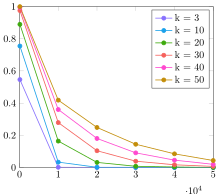

In [61]:
ax = Axis(xmin = 0.0, xmax = 50000.0, ymin = 0.0, ymax = 1.0, 
    style = "cycle list name = pastelcolors")
for i = 1:length(ks)
    push!(ax, Plots.Linear(sizes, recalls[:, i], legendentry = "k = $(ks[i])", 
            style = "thick", mark = "*"))
end
ax

In [75]:
#PGFPlots.save("recall_v_samplesize_k.pdf", ax, include_preamble = false);

In [76]:
recalls_256x4old = zeros(length(sizes), length(ks))
for i = 1:length(sizes)
    println("size = $(sizes[i])")
    recalls_256x4old[i, :] = vary_k(g256x4old, real_images, sizes[i], ks)
end

size = 100
size = 10000
size = 20000
size = 30000
size = 40000
size = 50000


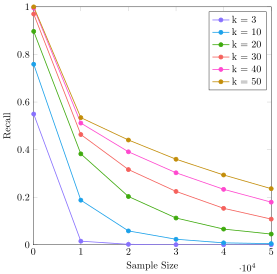

In [79]:
ax = Axis(xmin = 0.0, xmax = 50000.0, ymin = 0.0, ymax = 1.0, 
    style = "cycle list name = pastelcolors")
for i = 1:length(ks)
    push!(ax, Plots.Linear(sizes, recalls[:, i], legendentry = "k = $(ks[i])", 
            style = "thick", mark = "*"))
end
ax.height = "10cm"
ax.width = "10cm"
ax.xlabel = "Sample Size"
ax.ylabel = "Recall"
ax

In [81]:
#PGFPlots.save("recall_v_samplesize_k_old.tex", ax, include_preamble = false);